# XGBoost Classifier Model

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay


In [3]:
# Load the data
df = pd.read_csv('/Users/sabrinasayed/Documents/GitHub/Fake-Job-Posts/Data/Cleaned_Processed_Data.csv')


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Separate numericals and categoricals
numerical = ['telecommuting','has_company_logo','has_questions','description_length']
categorical = ['dominant_topic']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(), categorical)],
         remainder= 'passthrough')

# Build pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier())
])

# Split the data
X = df.drop('fraudulent', axis=1)
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the model
xgb = pipeline.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.95      0.68      0.79       181

    accuracy                           0.98      3576
   macro avg       0.96      0.84      0.89      3576
weighted avg       0.98      0.98      0.98      3576

0.9818232662192393


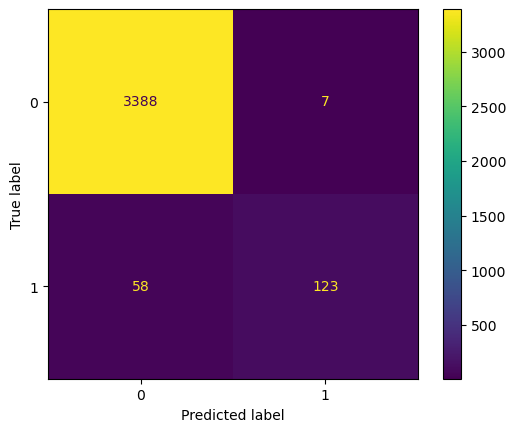

In [7]:

# Evaluate the model
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)

The F1 score is 89% and 98% accuracy.

# GridSearchCV Tuning

In [12]:
param_test1 = {
    "classifier__max_depth": range(3,6,10),
    "classifier__min_child_weight": range(1,3,5),
    "classifier__subsample": [0.8,0.9],
    "classifier__n_estimators": range(100,500,1000),
    "classifier__learning_rate": [.01,.1]
}

gsearch1 = GridSearchCV(
    estimator=pipeline,  # Use the full pipeline here
    param_grid=param_test1,
    n_jobs=2,
    cv=3,
    scoring='f1'
)

gsearch1.fit(X_train, y_train)

/Users/sabrinasayed/Documents/Flatiron/Phase 5/.conda/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['telecommuting',
                                                                          'has_company_logo',
                                                                          'has_questions',
                                                                          'description_length']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['dominant_topic'])])),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': range(3, 6, 10),
                         'classifier__min_child_weight': range(1, 3, 5),
                         'classifier__n_estimators': range(100, 500, 1000),
                         'classifier__subsample': [0.8, 0.9]},
             scoring='f1')

In [14]:
# Best parameters
print(gsearch1.best_params_)


{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.94      0.55      0.69       181

    accuracy                           0.98      3576
   macro avg       0.96      0.77      0.84      3576
weighted avg       0.97      0.98      0.97      3576

0.9753914988814317


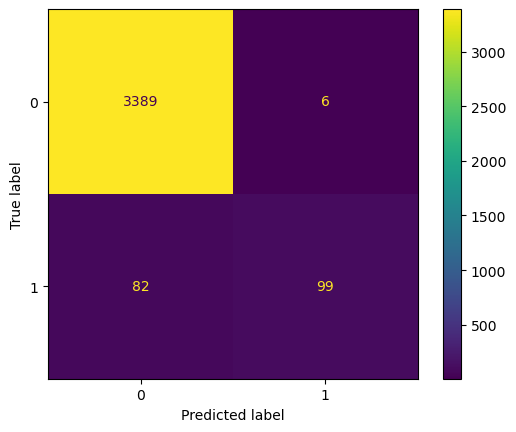

In [13]:
# Evaluate the model
y_pred = gsearch1.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(gsearch1, X_test, y_test)

The F1 score is 84% with an accuracy of 98%

In [19]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(np.exp(y_pred), np.exp(y_test))
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

RMSE: 0.2695485365603574


### Tuning with SMOTE 

In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", XGBClassifier(learning_rate=0.1, 
                                 max_depth=3,
                                 min_child_weight=1,
                                 n_estimators=100,
                                 subsample=0.8))
])

param_test2 = {
    "smote__k_neighbors": [3, 5, 7]
}

gsearch2 = GridSearchCV(
    estimator=pipeline,
    param_grid=param_test2,
    n_jobs=2,
    cv=3,
    scoring='f1')

gsearch2.fit(X_train, y_train)

# Best parameters
print(gsearch2.best_params_)

{'smote__k_neighbors': 7}


              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3395
           1       0.50      0.80      0.61       181

    accuracy                           0.95      3576
   macro avg       0.74      0.88      0.79      3576
weighted avg       0.96      0.95      0.95      3576

0.9493847874720358
RMSE: 0.3865760370737867


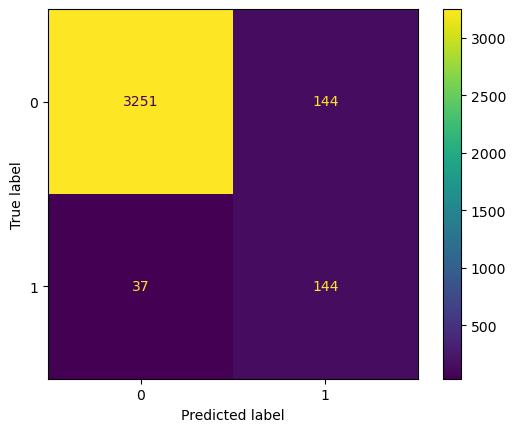

In [21]:
# Evaluate the model
y_pred_2= gsearch2.predict(X_test)
print(classification_report(y_test, y_pred_2))
print(accuracy_score(y_test, y_pred_2))
ConfusionMatrixDisplay.from_estimator(gsearch2, X_test, y_test)


mse = mean_squared_error(np.exp(y_pred_2), np.exp(y_test))
rmse2 = np.sqrt(mse)
print(f"RMSE: {rmse2}")


# XGBoost Model Evaluation

#### Despite hypertuning techniques, the original untuned model performs the best when taking into consideratoin F1 score and accuracy. The last model tuned with SMOTE has a 49% F1 score and 95% accuracy. The untuned model has a 89% F1 score and 98% accuracy.

## Best Model:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.95      0.68      0.79       181

    accuracy                           0.98      3576
   macro avg       0.96      0.84      0.89      3576
weighted avg       0.98      0.98      0.98      3576

0.9818232662192393
RMSE: 0.2316606766548223


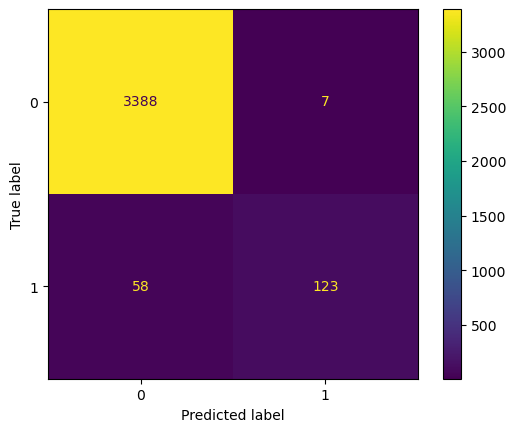

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(), categorical)],
         remainder= 'passthrough')

# Build pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier())
])

# Split the data
X = df.drop('fraudulent', axis=1)
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


best_model = pipeline.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

mse = mean_squared_error(np.exp(y_pred), np.exp(y_test))
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")